In [60]:
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import sympy as sp
from tbcontrol.symbolic import routh

- Função que converte a função de transferência da biblioteca control para uma função do sympy

In [61]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# DECLARANDO A FUNÇÃO DE TRANSFERÊNCIA

In [62]:
s = ctl.TransferFunction.s

G = 20*s/(20*s**4 + 415*s**3 + 4800*s**2 + 5000*s + 20000)
G

TransferFunction(array([20,  0]), array([   20,   415,  4800,  5000, 20000]))

# DANDO UM STEP

- Resposta Natural

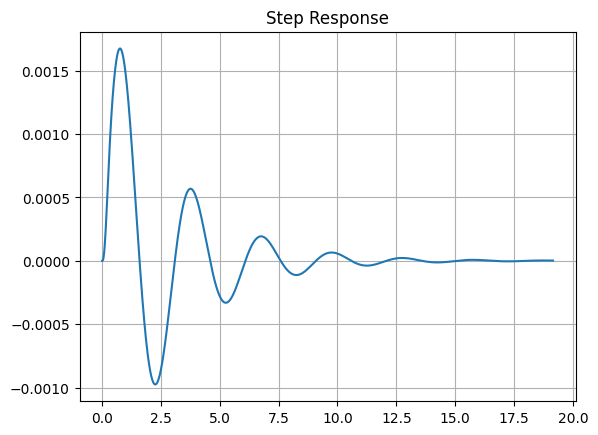

In [63]:
time, response = ctl.step_response(G)
plt.plot(time, response)

plt.title('Step Response')
plt.grid()
plt.show()

- Resposta Forçada $\Rightarrow$ Degrau de Amplitude 10

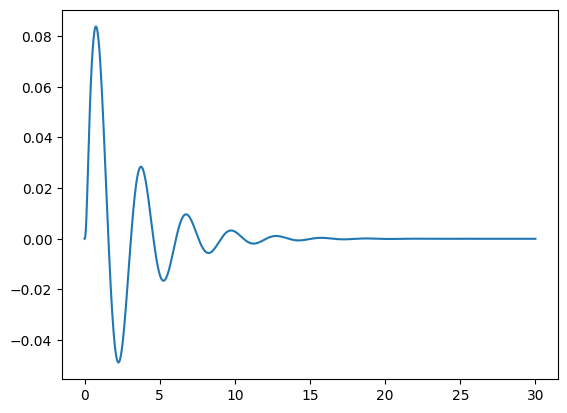

In [64]:
T = np.linspace(0, 30, 1000)
U = 50 * np.ones(len(T))

time, response = ctl.forced_response(G, T=T, U=U)
plt.plot(time, response)

# INFORMAÇÕES DO SISTEMA

In [65]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  inf
valor de pico:  0.08375329652187542
tempo de pico:  0.7507507507507507
tempo de assentamento:  None
valor final:  -3.0297565685786067e-07
erro:  0.9999996970243431


- Polos e zeros da TF

In [77]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)

print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

polos:  (-10.014+10.988j) (-10.014-10.988j) (-0.361+2.096j) (-0.361-2.096j)
zeros:  0j


# ROOT LOCUS

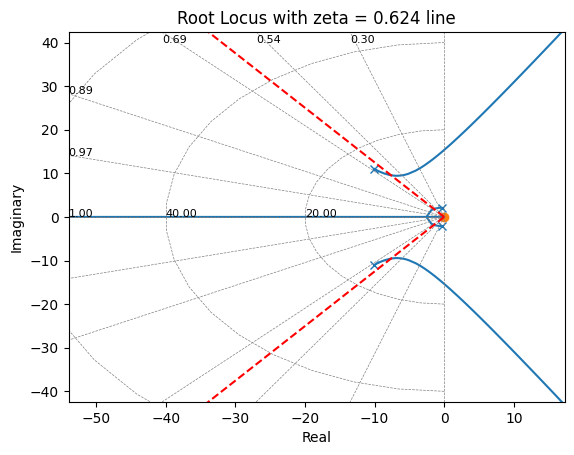

In [67]:
def zGrid(zeta):
    angle  = np.arccos(zeta)
    radius = np.linspace(0, 100, 400)

    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    
    plt.plot(-x, y, 'r--')
    plt.plot(-x, -y, 'r--')

    plt.title(f'Root Locus with zeta = {zeta} line')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()


ctl.root_locus(G)
zGrid(zeta=0.624)
plt.show()

# TABELA DE ROUTH

In [68]:
K, s = sp.symbols('K s')
G_s  = K * sympyFunction(G)

T = sp.cancel(G_s/(1 + G_s))
T = roundSympyFunction(T)
T

4*K*s/(4*K*s + 4*s**4 + 83*s**3 + 960*s**2 + 1000*s + 4000)

In [69]:
num, den = sp.fraction(T)

routhTable = routh(sp.poly(den, s))
routhTable = roundSympyFunction(routhTable)

routhTable

Matrix([
[                                       4,        960, 4000],
[                                      83, 4*K + 1000,    0],
[                      75680/83 - 16*K/83,       4000,    0],
[2*(2*K**2 - 8960*K - 1503875)/(K - 4730),          0,    0],
[                                    4000,          0,    0]])

In [70]:
firstRow = routhTable[:, 0]
firstRow

Matrix([
[                                       4],
[                                      83],
[                      75680/83 - 16*K/83],
[2*(2*K**2 - 8960*K - 1503875)/(K - 4730)],
[                                    4000]])

In [71]:
equations = [value > 0 for value in firstRow]
equations

[True,
 True,
 75680/83 - 16*K/83 > 0,
 2*(2*K**2 - 8960*K - 1503875)/(K - 4730) > 0,
 True]

In [72]:
solutions  = sp.solve(equations, K)
solutions  = roundSympyFunction(solutions, 3)

print(solutions)
solutions

(-oo < K) & (K < 4730) & (((4730 < K) & (K < oo)) | ((K < 2240 + 415*sqrt(134)/2) & (2240 - 415*sqrt(134)/2 < K)))


(-oo < K) & (K < 4730) & (((4730 < K) & (K < oo)) | ((K < 2240 + 415*sqrt(134)/2) & (2240 - 415*sqrt(134)/2 < K)))

# DIAGRAMA DE BODE

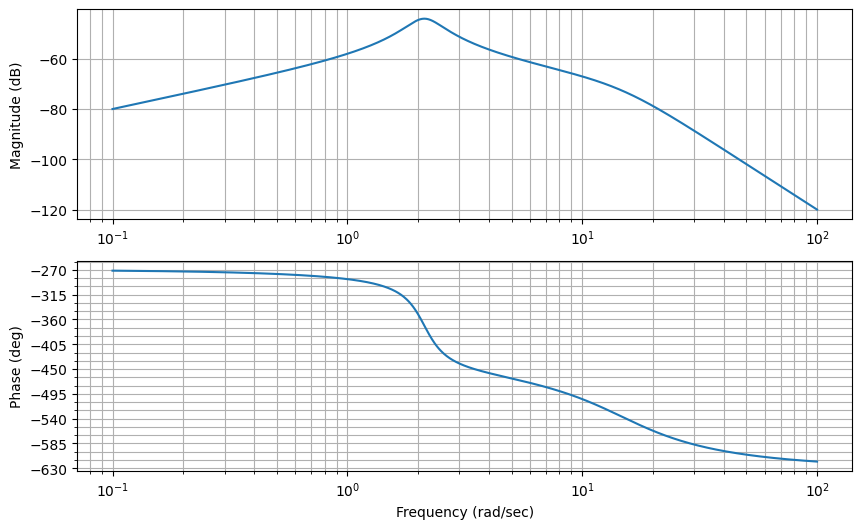

In [73]:
plt.figure(figsize=(10, 6))
mag, phase, omega = ctl.bode_plot(G, dB=True)
plt.show()

# DIAGRAMA DE NYQUIST

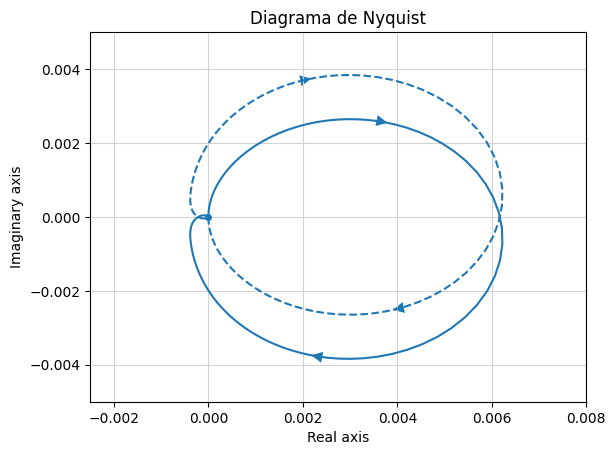

In [74]:
ctl.nyquist(G)
plt.xlim(-0.0025, 0.008)
plt.ylim(-0.005, 0.005)

plt.title('Diagrama de Nyquist')
plt.show()

# FEEDBACK - REALIMENTAÇÃO UNITÁRIA

In [75]:
G_feedback = ctl.feedback(G, 1)
G_feedback

TransferFunction(array([20,  0]), array([   20,   415,  4800,  5020, 20000]))

In [76]:
time, response = ctl.step_response(G_feedback)
getAllInfo(time, response)

overshoot:  825.6186114596896
valor de pico:  0.0016733571213564814
tempo de pico:  0.758587502909812
tempo de assentamento:  None
valor final:  2.024340001734988e-06
erro:  0.9999979756599983
